In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import shutil
import glob

In [3]:
#train.zip, test.zipが格納されている場所からcontent上にファイルをコピー.
#colab上のディレクトリ(content上)にzipファイルを移動し解凍を行うと、画像の読み込みが速くなる.

# zipファイルの展開先ディレクトリの確認
assert os.getcwd() == '/content', 'Curent directory is not "/content"'

# train
if "train.zip" not in os.listdir("/content/"):
    shutil.copy("/content/drive/MyDrive/MyStudy/MySIGNATE/package-classification-comp/data/train.zip",
                "/content/train.zip")
if "train" not in os.listdir("/content/"):
    !unzip /content/train.zip

# test
if "test.zip" not in os.listdir("/content/"):
    shutil.copy("/content/drive/MyDrive/MyStudy/MySIGNATE/package-classification-comp/data/test.zip",
                "/content/test.zip")
if "test" not in os.listdir("/content/"):
    !unzip /content/test.zip

Archive:  /content/train.zip
   creating: train/
  inflating: train/1804.png          
  inflating: train/1810.png          
  inflating: train/0298.png          
  inflating: train/1186.png          
  inflating: train/1838.png          
  inflating: train/1192.png          
  inflating: train/1179.png          
  inflating: train/0267.png          
  inflating: train/0501.png          
  inflating: train/0515.png          
  inflating: train/0273.png          
  inflating: train/1145.png          
  inflating: train/1623.png          
  inflating: train/0529.png          
  inflating: train/1637.png          
  inflating: train/1151.png          
  inflating: train/0918.png          
  inflating: train/0924.png          
  inflating: train/1384.png          
  inflating: train/1390.png          
  inflating: train/0930.png          
  inflating: train/0703.png          
  inflating: train/2114.png          
  inflating: train/0065.png          
  inflating: train/0071.png          
 

In [4]:
# 作業ディレクトリへの移動
%cd /content/drive/MyDrive/MyStudy/MySIGNATE/package-classification-comp/

/content/drive/MyDrive/MyStudy/MySIGNATE/package-classification-comp


In [5]:
#必要なライブラリのインポート
import re, gc, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import warnings, random
import cv2

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms
import torchvision.models as models

In [6]:
#再現性を出すために必要な関数
def worker_init_fn(worker_id):
    torch.manual_seed(worker_id)
    random.seed(worker_id)
    np.random.seed(worker_id)
    torch.cuda.manual_seed(worker_id)
    os.environ['PYTHONHASHSEED'] = str(worker_id)

def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [7]:
# ラベルデータの確認
data = pd.read_csv('data/train.csv')
data.head()

,image_name,label
0,0000.png,0
1,0001.png,1
2,0002.png,1
3,0003.png,1
4,0004.png,0


In [8]:
# 0: 飲料, 1: 食料
data.groupby(['label']).count()
# data['label'].value_counts()

,image_name
label,
0,994
1,1182


image shape: (512, 512, 3)


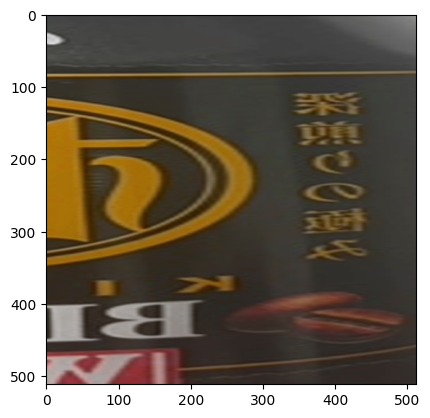

In [9]:
image = cv2.imread(f'/content/train/0000.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(f'image shape: {image.shape}')

plt.imshow(image)
plt.show()

In [10]:
data[data['image_name']=='0000.png']

,image_name,label
0,0000.png,0


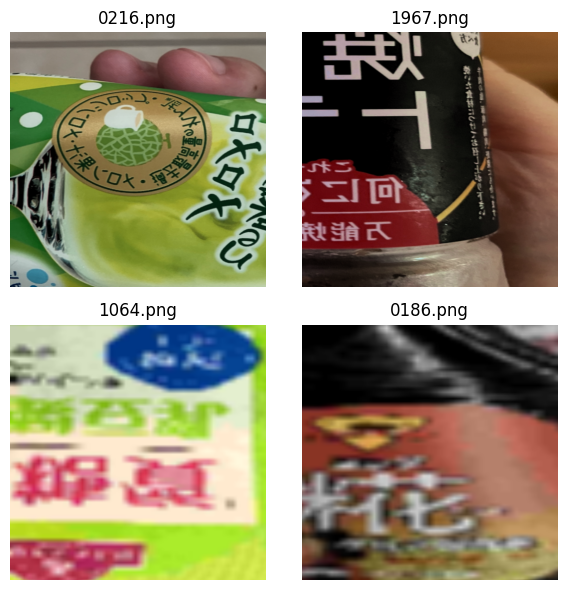

In [11]:
# 飲料
data_0 = data[data["label"] == 0].sample(n=4).reset_index(drop=True) # 元のインデックス情報は消す
fig, axes = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)
for i, d in data_0.iterrows():
    # print(i)
    # print(d)
    image_name = d["image_name"]
    image = cv2.imread(f"/content/train/{image_name}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[i//2, i%2].imshow(image)
    axes[i//2, i%2].set_axis_off()
    axes[i//2, i%2].set_title(image_name)
plt.show()

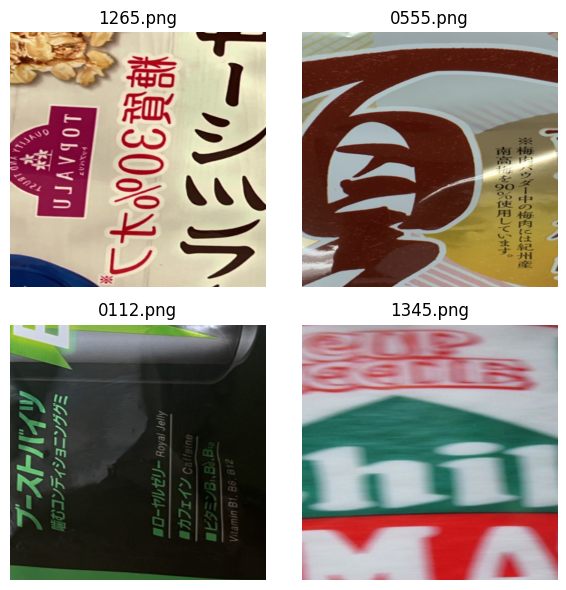

In [12]:
# 食料
data_1 = data[data["label"] == 1].sample(n=4).reset_index(drop=True) # 元のインデックス情報は消す
fig, axes = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)
for i, d in data_1.iterrows():
    image_name = d["image_name"]
    image = cv2.imread(f"/content/train/{image_name}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[i//2, i%2].imshow(image)
    axes[i//2, i%2].set_axis_off()
    axes[i//2, i%2].set_title(image_name)
plt.show()

In [13]:
# データの正規化
import glob

imgs_t = torch.zeros(3, 512, 512, 2176)

img_paths = glob.glob('/content/train/*.png')

image_ToTensor = transforms.ToTensor()

for i, path in enumerate(img_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_t = image_ToTensor(img)
    imgs_t[:, :, :, i] = img_t

In [14]:
imgs_t.shape

torch.Size([3, 512, 512, 2176])

In [15]:
imgs_t.view(3, -1).mean(dim=1)

tensor([0.5433, 0.4686, 0.4039])

In [16]:
imgs_t.view(3, -1).std(dim=1)

tensor([0.2455, 0.2476, 0.2497])